In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
import backbone
from dataloader import create_dataloader

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.00001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Create model and move to device
model = backbone.backbone['densenet201'](num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# create empty lists to store predicted probabilities and true labels for each epoch
train_preds_all, train_labels_all = [], []
val_preds_all, val_labels_all = [], []
# create a list to store the ROC plots
roc_plots = []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
#roc_epochs = [int(num_epochs / 4), int(num_epochs / 2), int(3 * num_epochs / 4), num_epochs]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        train_preds += outputs.sigmoid().tolist()
        train_labels += labels.tolist()


    epoch_loss_train = running_loss / len(train_dataloader)
    print(f"Training Loss: {epoch_loss_train:.4f}")
    
    # calculate ROC AUC score for train set
    train_roc_auc = roc_auc_score(train_labels, train_preds)
    print(f"Train ROC AUC Score: {train_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    train_preds_all.append(train_preds)
    train_labels_all.append(train_labels)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())

            running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.sigmoid().tolist()
        val_labels += labels.tolist()

    epoch_loss_val = running_loss / len(val_dataloader)
    print(f"Validation Loss: {epoch_loss_val:.4f}")

    # calculate ROC AUC score for validation set
    val_roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"Validation ROC AUC Score: {val_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    val_preds_all.append(val_preds)
    val_labels_all.append(val_labels)
    
    # calculate F1 score for validation set using the defined thresholds
    val_preds_thresholded = [[1 if pred[i] >= thresholds[i] else 0 for i in range(num_labels)] for pred in val_preds]
    val_f1_score = f1_score(val_labels, val_preds_thresholded, average='macro')
    print(f"Validation F1 Score: {val_f1_score:.4f}")
        
    f1_arr.append(val_f1_score)
    loss_arr.append(epoch_loss_val)
    
    # check if the current epoch is in the list of epochs to plot ROC curve
    if epoch+1 in roc_epochs:
        # calculate ROC curve and AUC score for validation set
        fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
        roc_fpr.append(fpr)
        roc_tpr.append(tpr)
        roc_auc.append(auc(fpr, tpr))

    print() # empty line for spacing

Epoch 1/200
----------


100%|██████████| 111/111 [00:53<00:00,  2.07it/s]


Training Loss: 4.7291
Train ROC AUC Score: 0.6952


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Validation Loss: 3.3942
Validation ROC AUC Score: 0.8075
Validation F1 Score: 0.1923

Epoch 2/200
----------


100%|██████████| 111/111 [00:52<00:00,  2.13it/s]


Training Loss: 4.1120
Train ROC AUC Score: 0.8215


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 3.0688
Validation ROC AUC Score: 0.8555
Validation F1 Score: 0.2067

Epoch 3/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 3.7838
Train ROC AUC Score: 0.8558


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Validation Loss: 2.7698
Validation ROC AUC Score: 0.8778
Validation F1 Score: 0.2107

Epoch 4/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.99it/s]


Training Loss: 3.4358
Train ROC AUC Score: 0.8777


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 2.5558
Validation ROC AUC Score: 0.8915
Validation F1 Score: 0.2171

Epoch 5/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 3.2914
Train ROC AUC Score: 0.8899


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 2.3774
Validation ROC AUC Score: 0.9019
Validation F1 Score: 0.2239

Epoch 6/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 3.0850
Train ROC AUC Score: 0.9071


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 2.3044
Validation ROC AUC Score: 0.9076
Validation F1 Score: 0.2188

Epoch 7/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.88it/s]


Training Loss: 3.0622
Train ROC AUC Score: 0.9103


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 2.2540
Validation ROC AUC Score: 0.9122
Validation F1 Score: 0.2236

Epoch 8/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 2.9188
Train ROC AUC Score: 0.9200


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 2.1569
Validation ROC AUC Score: 0.9176
Validation F1 Score: 0.2254

Epoch 9/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.99it/s]


Training Loss: 2.8234
Train ROC AUC Score: 0.9280


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 2.0889
Validation ROC AUC Score: 0.9229
Validation F1 Score: 0.2269

Epoch 10/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 2.6609
Train ROC AUC Score: 0.9319


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 2.0785
Validation ROC AUC Score: 0.9234
Validation F1 Score: 0.2290

Epoch 11/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 2.5848
Train ROC AUC Score: 0.9390


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 2.0072
Validation ROC AUC Score: 0.9262
Validation F1 Score: 0.2316

Epoch 12/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 2.5327
Train ROC AUC Score: 0.9458


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.9350
Validation ROC AUC Score: 0.9283
Validation F1 Score: 0.2358

Epoch 13/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 2.4637
Train ROC AUC Score: 0.9462


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.9045
Validation ROC AUC Score: 0.9277
Validation F1 Score: 0.2342

Epoch 14/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 2.3550
Train ROC AUC Score: 0.9527


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.9299
Validation ROC AUC Score: 0.9277
Validation F1 Score: 0.2336

Epoch 15/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 2.3634
Train ROC AUC Score: 0.9541


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Validation Loss: 1.8855
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2342

Epoch 16/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.88it/s]


Training Loss: 2.2107
Train ROC AUC Score: 0.9585


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.8411
Validation ROC AUC Score: 0.9274
Validation F1 Score: 0.2371

Epoch 17/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 2.1864
Train ROC AUC Score: 0.9645


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8385
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2383

Epoch 18/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 2.1560
Train ROC AUC Score: 0.9667


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7512
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2429

Epoch 19/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 2.0684
Train ROC AUC Score: 0.9680


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7408
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2450

Epoch 20/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 2.0912
Train ROC AUC Score: 0.9698


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7802
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2414

Epoch 21/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 2.0164
Train ROC AUC Score: 0.9715


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6859
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2470

Epoch 22/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.9868
Train ROC AUC Score: 0.9728


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7252
Validation ROC AUC Score: 0.9316
Validation F1 Score: 0.2407

Epoch 23/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.9687
Train ROC AUC Score: 0.9738


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7205
Validation ROC AUC Score: 0.9332
Validation F1 Score: 0.2453

Epoch 24/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.9451
Train ROC AUC Score: 0.9768


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6706
Validation ROC AUC Score: 0.9353
Validation F1 Score: 0.2434

Epoch 25/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.8653
Train ROC AUC Score: 0.9803


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6955
Validation ROC AUC Score: 0.9337
Validation F1 Score: 0.2404

Epoch 26/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.8239
Train ROC AUC Score: 0.9788


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6694
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.2462

Epoch 27/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.7820
Train ROC AUC Score: 0.9802


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6777
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2425

Epoch 28/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.7802
Train ROC AUC Score: 0.9810


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6520
Validation ROC AUC Score: 0.9364
Validation F1 Score: 0.2425

Epoch 29/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.7288
Train ROC AUC Score: 0.9817


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.6403
Validation ROC AUC Score: 0.9381
Validation F1 Score: 0.2460

Epoch 30/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.7255
Train ROC AUC Score: 0.9822


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.6493
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2437

Epoch 31/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.7587
Train ROC AUC Score: 0.9833


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6443
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.2470

Epoch 32/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.99it/s]


Training Loss: 1.6619
Train ROC AUC Score: 0.9848


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6445
Validation ROC AUC Score: 0.9378
Validation F1 Score: 0.2487

Epoch 33/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.6594
Train ROC AUC Score: 0.9851


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.5880
Validation ROC AUC Score: 0.9373
Validation F1 Score: 0.2428

Epoch 34/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.6897
Train ROC AUC Score: 0.9861


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6088
Validation ROC AUC Score: 0.9381
Validation F1 Score: 0.2459

Epoch 35/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.6082
Train ROC AUC Score: 0.9882


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6046
Validation ROC AUC Score: 0.9402
Validation F1 Score: 0.2488

Epoch 36/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.5785
Train ROC AUC Score: 0.9885


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.5790
Validation ROC AUC Score: 0.9380
Validation F1 Score: 0.2500

Epoch 37/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.6020
Train ROC AUC Score: 0.9889


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.6304
Validation ROC AUC Score: 0.9389
Validation F1 Score: 0.2484

Epoch 38/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.5964
Train ROC AUC Score: 0.9884


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6284
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2469

Epoch 39/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.5762
Train ROC AUC Score: 0.9885


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5960
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2504

Epoch 40/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.5555
Train ROC AUC Score: 0.9900


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6066
Validation ROC AUC Score: 0.9378
Validation F1 Score: 0.2482

Epoch 41/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.5335
Train ROC AUC Score: 0.9905


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5588
Validation ROC AUC Score: 0.9397
Validation F1 Score: 0.2520

Epoch 42/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.5075
Train ROC AUC Score: 0.9915


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5481
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2581

Epoch 43/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.5010
Train ROC AUC Score: 0.9913


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.5746
Validation ROC AUC Score: 0.9385
Validation F1 Score: 0.2494

Epoch 44/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.4925
Train ROC AUC Score: 0.9918


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.5904
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.2537

Epoch 45/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.4605
Train ROC AUC Score: 0.9917


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5474
Validation ROC AUC Score: 0.9401
Validation F1 Score: 0.2483

Epoch 46/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.5174
Train ROC AUC Score: 0.9917


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5824
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2502

Epoch 47/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.4660
Train ROC AUC Score: 0.9919


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.5557
Validation ROC AUC Score: 0.9382
Validation F1 Score: 0.2526

Epoch 48/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.4683
Train ROC AUC Score: 0.9917


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5402
Validation ROC AUC Score: 0.9376
Validation F1 Score: 0.2539

Epoch 49/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.4221
Train ROC AUC Score: 0.9923


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5569
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2540

Epoch 50/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.4088
Train ROC AUC Score: 0.9930


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5481
Validation ROC AUC Score: 0.9384
Validation F1 Score: 0.2547

Epoch 51/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.4631
Train ROC AUC Score: 0.9935


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.5312
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.2592

Epoch 52/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.4531
Train ROC AUC Score: 0.9937


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.5198
Validation ROC AUC Score: 0.9397
Validation F1 Score: 0.2559

Epoch 53/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.4649
Train ROC AUC Score: 0.9925


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5562
Validation ROC AUC Score: 0.9390
Validation F1 Score: 0.2573

Epoch 54/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.4069
Train ROC AUC Score: 0.9939


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.5115
Validation ROC AUC Score: 0.9382
Validation F1 Score: 0.2571

Epoch 55/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.3748
Train ROC AUC Score: 0.9935


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5038
Validation ROC AUC Score: 0.9427
Validation F1 Score: 0.2635

Epoch 56/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.3099
Train ROC AUC Score: 0.9939


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.4938
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2560

Epoch 57/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.87it/s]


Training Loss: 1.4345
Train ROC AUC Score: 0.9939


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5270
Validation ROC AUC Score: 0.9387
Validation F1 Score: 0.2538

Epoch 58/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.4648
Train ROC AUC Score: 0.9929


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5225
Validation ROC AUC Score: 0.9392
Validation F1 Score: 0.2596

Epoch 59/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.4323
Train ROC AUC Score: 0.9930


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5297
Validation ROC AUC Score: 0.9367
Validation F1 Score: 0.2631

Epoch 60/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.3362
Train ROC AUC Score: 0.9950


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5141
Validation ROC AUC Score: 0.9382
Validation F1 Score: 0.2585

Epoch 61/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.4261
Train ROC AUC Score: 0.9943


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.5187
Validation ROC AUC Score: 0.9381
Validation F1 Score: 0.2559

Epoch 62/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.3416
Train ROC AUC Score: 0.9945


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.4977
Validation ROC AUC Score: 0.9378
Validation F1 Score: 0.2585

Epoch 63/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.3826
Train ROC AUC Score: 0.9941


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.5365
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2538

Epoch 64/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.3215
Train ROC AUC Score: 0.9952


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.5502
Validation ROC AUC Score: 0.9371
Validation F1 Score: 0.2574

Epoch 65/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.2937
Train ROC AUC Score: 0.9957


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.5463
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.2606

Epoch 66/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.3597
Train ROC AUC Score: 0.9951


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5796
Validation ROC AUC Score: 0.9403
Validation F1 Score: 0.2667

Epoch 67/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.3408
Train ROC AUC Score: 0.9946


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.5239
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2627

Epoch 68/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.3160
Train ROC AUC Score: 0.9959


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.5088
Validation ROC AUC Score: 0.9419
Validation F1 Score: 0.2581

Epoch 69/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.2796
Train ROC AUC Score: 0.9950


100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Validation Loss: 1.5453
Validation ROC AUC Score: 0.9414
Validation F1 Score: 0.2639

Epoch 70/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.3079
Train ROC AUC Score: 0.9950


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.4800
Validation ROC AUC Score: 0.9429
Validation F1 Score: 0.2696

Epoch 71/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.2938
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5239
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2639

Epoch 72/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.2921
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5291
Validation ROC AUC Score: 0.9422
Validation F1 Score: 0.2637

Epoch 73/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.2127
Train ROC AUC Score: 0.9963


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.5959
Validation ROC AUC Score: 0.9404
Validation F1 Score: 0.2699

Epoch 74/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.86it/s]


Training Loss: 1.2995
Train ROC AUC Score: 0.9956


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5250
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2611

Epoch 75/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.2980
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.4896
Validation ROC AUC Score: 0.9419
Validation F1 Score: 0.2604

Epoch 76/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.2582
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5375
Validation ROC AUC Score: 0.9384
Validation F1 Score: 0.2611

Epoch 77/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2912
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5331
Validation ROC AUC Score: 0.9381
Validation F1 Score: 0.2613

Epoch 78/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.3420
Train ROC AUC Score: 0.9955


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5133
Validation ROC AUC Score: 0.9400
Validation F1 Score: 0.2595

Epoch 79/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.2986
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.4835
Validation ROC AUC Score: 0.9422
Validation F1 Score: 0.2635

Epoch 80/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2498
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.5304
Validation ROC AUC Score: 0.9416
Validation F1 Score: 0.2690

Epoch 81/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.2402
Train ROC AUC Score: 0.9965


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5394
Validation ROC AUC Score: 0.9437
Validation F1 Score: 0.2589

Epoch 82/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.2636
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.4977
Validation ROC AUC Score: 0.9427
Validation F1 Score: 0.2656

Epoch 83/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.2340
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5188
Validation ROC AUC Score: 0.9446
Validation F1 Score: 0.2721

Epoch 84/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.2236
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5265
Validation ROC AUC Score: 0.9416
Validation F1 Score: 0.2670

Epoch 85/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.2969
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5266
Validation ROC AUC Score: 0.9417
Validation F1 Score: 0.2617

Epoch 86/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2176
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5059
Validation ROC AUC Score: 0.9458
Validation F1 Score: 0.2647

Epoch 87/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.2865
Train ROC AUC Score: 0.9971


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.5852
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2631

Epoch 88/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.3001
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5477
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2665

Epoch 89/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1962
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.5370
Validation ROC AUC Score: 0.9422
Validation F1 Score: 0.2674

Epoch 90/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.2470
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5209
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2652

Epoch 91/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1986
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5181
Validation ROC AUC Score: 0.9427
Validation F1 Score: 0.2650

Epoch 92/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.2327
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.5217
Validation ROC AUC Score: 0.9437
Validation F1 Score: 0.2627

Epoch 93/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.2288
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.5387
Validation ROC AUC Score: 0.9405
Validation F1 Score: 0.2651

Epoch 94/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.2082
Train ROC AUC Score: 0.9977


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.5046
Validation ROC AUC Score: 0.9444
Validation F1 Score: 0.2677

Epoch 95/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.2359
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.5309
Validation ROC AUC Score: 0.9420
Validation F1 Score: 0.2630

Epoch 96/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1939
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5236
Validation ROC AUC Score: 0.9421
Validation F1 Score: 0.2684

Epoch 97/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1694
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5281
Validation ROC AUC Score: 0.9431
Validation F1 Score: 0.2608

Epoch 98/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.2849
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.5378
Validation ROC AUC Score: 0.9422
Validation F1 Score: 0.2746

Epoch 99/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1483
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.5565
Validation ROC AUC Score: 0.9371
Validation F1 Score: 0.2640

Epoch 100/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2082
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5331
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2576

Epoch 101/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.2705
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5531
Validation ROC AUC Score: 0.9431
Validation F1 Score: 0.2679

Epoch 102/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2293
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.5255
Validation ROC AUC Score: 0.9448
Validation F1 Score: 0.2642

Epoch 103/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.2656
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5363
Validation ROC AUC Score: 0.9419
Validation F1 Score: 0.2650

Epoch 104/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.1860
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5475
Validation ROC AUC Score: 0.9409
Validation F1 Score: 0.2735

Epoch 105/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.2067
Train ROC AUC Score: 0.9977


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5445
Validation ROC AUC Score: 0.9401
Validation F1 Score: 0.2720

Epoch 106/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.2493
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.5919
Validation ROC AUC Score: 0.9414
Validation F1 Score: 0.2728

Epoch 107/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.1600
Train ROC AUC Score: 0.9964


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.5657
Validation ROC AUC Score: 0.9402
Validation F1 Score: 0.2679

Epoch 108/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.2186
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6214
Validation ROC AUC Score: 0.9391
Validation F1 Score: 0.2658

Epoch 109/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1881
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5638
Validation ROC AUC Score: 0.9431
Validation F1 Score: 0.2603

Epoch 110/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1353
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.5707
Validation ROC AUC Score: 0.9394
Validation F1 Score: 0.2659

Epoch 111/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1299
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.5184
Validation ROC AUC Score: 0.9426
Validation F1 Score: 0.2678

Epoch 112/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1619
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.5659
Validation ROC AUC Score: 0.9423
Validation F1 Score: 0.2746

Epoch 113/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.2061
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5584
Validation ROC AUC Score: 0.9425
Validation F1 Score: 0.2701

Epoch 114/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1423
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.5346
Validation ROC AUC Score: 0.9455
Validation F1 Score: 0.2693

Epoch 115/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.1439
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.5538
Validation ROC AUC Score: 0.9421
Validation F1 Score: 0.2725

Epoch 116/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1733
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.5469
Validation ROC AUC Score: 0.9434
Validation F1 Score: 0.2663

Epoch 117/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.1662
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.5669
Validation ROC AUC Score: 0.9434
Validation F1 Score: 0.2723

Epoch 118/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1726
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.5674
Validation ROC AUC Score: 0.9457
Validation F1 Score: 0.2691

Epoch 119/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1548
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.5953
Validation ROC AUC Score: 0.9437
Validation F1 Score: 0.2744

Epoch 120/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.1306
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.5610
Validation ROC AUC Score: 0.9423
Validation F1 Score: 0.2697

Epoch 121/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1408
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.5671
Validation ROC AUC Score: 0.9408
Validation F1 Score: 0.2741

Epoch 122/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1568
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5737
Validation ROC AUC Score: 0.9425
Validation F1 Score: 0.2768

Epoch 123/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1927
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.5623
Validation ROC AUC Score: 0.9432
Validation F1 Score: 0.2737

Epoch 124/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.88it/s]


Training Loss: 1.1546
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6209
Validation ROC AUC Score: 0.9439
Validation F1 Score: 0.2696

Epoch 125/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1236
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6580
Validation ROC AUC Score: 0.9395
Validation F1 Score: 0.2840

Epoch 126/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.86it/s]


Training Loss: 1.1282
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.5731
Validation ROC AUC Score: 0.9423
Validation F1 Score: 0.2654

Epoch 127/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1883
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.5903
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2698

Epoch 128/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1821
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.6098
Validation ROC AUC Score: 0.9425
Validation F1 Score: 0.2728

Epoch 129/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1338
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6220
Validation ROC AUC Score: 0.9445
Validation F1 Score: 0.2782

Epoch 130/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1609
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Validation Loss: 1.6078
Validation ROC AUC Score: 0.9410
Validation F1 Score: 0.2715

Epoch 131/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.1641
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.6453
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2712

Epoch 132/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.1793
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6017
Validation ROC AUC Score: 0.9426
Validation F1 Score: 0.2652

Epoch 133/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1697
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6302
Validation ROC AUC Score: 0.9420
Validation F1 Score: 0.2759

Epoch 134/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.1156
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6052
Validation ROC AUC Score: 0.9413
Validation F1 Score: 0.2675

Epoch 135/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.1421
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6326
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2740

Epoch 136/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.2057
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.5347
Validation ROC AUC Score: 0.9413
Validation F1 Score: 0.2718

Epoch 137/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0914
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.5967
Validation ROC AUC Score: 0.9370
Validation F1 Score: 0.2792

Epoch 138/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.1229
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5906
Validation ROC AUC Score: 0.9396
Validation F1 Score: 0.2700

Epoch 139/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.99it/s]


Training Loss: 1.1317
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.5671
Validation ROC AUC Score: 0.9410
Validation F1 Score: 0.2695

Epoch 140/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1024
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6167
Validation ROC AUC Score: 0.9391
Validation F1 Score: 0.2701

Epoch 141/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1064
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.5781
Validation ROC AUC Score: 0.9434
Validation F1 Score: 0.2673

Epoch 142/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1200
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6064
Validation ROC AUC Score: 0.9399
Validation F1 Score: 0.2733

Epoch 143/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1116
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.5807
Validation ROC AUC Score: 0.9418
Validation F1 Score: 0.2689

Epoch 144/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.1274
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6134
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2655

Epoch 145/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1251
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Validation Loss: 1.6641
Validation ROC AUC Score: 0.9360
Validation F1 Score: 0.2632

Epoch 146/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.1400
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6532
Validation ROC AUC Score: 0.9385
Validation F1 Score: 0.2662

Epoch 147/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1598
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6698
Validation ROC AUC Score: 0.9410
Validation F1 Score: 0.2646

Epoch 148/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.1578
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.5877
Validation ROC AUC Score: 0.9425
Validation F1 Score: 0.2684

Epoch 149/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.88it/s]


Training Loss: 1.1242
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6530
Validation ROC AUC Score: 0.9385
Validation F1 Score: 0.2715

Epoch 150/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0938
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.6119
Validation ROC AUC Score: 0.9392
Validation F1 Score: 0.2647

Epoch 151/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.1619
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6737
Validation ROC AUC Score: 0.9424
Validation F1 Score: 0.2755

Epoch 152/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1206
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6400
Validation ROC AUC Score: 0.9417
Validation F1 Score: 0.2673

Epoch 153/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.0787
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6534
Validation ROC AUC Score: 0.9421
Validation F1 Score: 0.2757

Epoch 154/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.0876
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6662
Validation ROC AUC Score: 0.9393
Validation F1 Score: 0.2752

Epoch 155/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1916
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6244
Validation ROC AUC Score: 0.9424
Validation F1 Score: 0.2809

Epoch 156/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0728
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6445
Validation ROC AUC Score: 0.9431
Validation F1 Score: 0.2822

Epoch 157/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1195
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6292
Validation ROC AUC Score: 0.9434
Validation F1 Score: 0.2752

Epoch 158/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.0637
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.6318
Validation ROC AUC Score: 0.9462
Validation F1 Score: 0.2747

Epoch 159/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.0854
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.6001
Validation ROC AUC Score: 0.9430
Validation F1 Score: 0.2711

Epoch 160/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1335
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.6023
Validation ROC AUC Score: 0.9430
Validation F1 Score: 0.2742

Epoch 161/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.1185
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.5822
Validation ROC AUC Score: 0.9440
Validation F1 Score: 0.2793

Epoch 162/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1539
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.5989
Validation ROC AUC Score: 0.9424
Validation F1 Score: 0.2814

Epoch 163/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.1147
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.6085
Validation ROC AUC Score: 0.9423
Validation F1 Score: 0.2708

Epoch 164/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.1188
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6133
Validation ROC AUC Score: 0.9409
Validation F1 Score: 0.2729

Epoch 165/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.1119
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Validation Loss: 1.6326
Validation ROC AUC Score: 0.9394
Validation F1 Score: 0.2787

Epoch 166/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.98it/s]


Training Loss: 1.1843
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6001
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.2770

Epoch 167/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.0870
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6230
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2795

Epoch 168/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0880
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6119
Validation ROC AUC Score: 0.9404
Validation F1 Score: 0.2780

Epoch 169/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.0234
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6319
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2833

Epoch 170/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0334
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6275
Validation ROC AUC Score: 0.9384
Validation F1 Score: 0.2806

Epoch 171/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.1071
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6563
Validation ROC AUC Score: 0.9374
Validation F1 Score: 0.2801

Epoch 172/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0842
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6951
Validation ROC AUC Score: 0.9379
Validation F1 Score: 0.2751

Epoch 173/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.85it/s]


Training Loss: 1.0983
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7353
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.2655

Epoch 174/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1240
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.6321
Validation ROC AUC Score: 0.9409
Validation F1 Score: 0.2757

Epoch 175/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.1047
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6802
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2731

Epoch 176/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.0690
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6709
Validation ROC AUC Score: 0.9404
Validation F1 Score: 0.2766

Epoch 177/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0725
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.6988
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2817

Epoch 178/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.0165
Train ROC AUC Score: 0.9992


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6722
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2678

Epoch 179/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0947
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Validation Loss: 1.6576
Validation ROC AUC Score: 0.9393
Validation F1 Score: 0.2757

Epoch 180/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.0918
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6240
Validation ROC AUC Score: 0.9392
Validation F1 Score: 0.2757

Epoch 181/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.96it/s]


Training Loss: 1.1466
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6554
Validation ROC AUC Score: 0.9389
Validation F1 Score: 0.2711

Epoch 182/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.92it/s]


Training Loss: 1.1038
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6219
Validation ROC AUC Score: 0.9412
Validation F1 Score: 0.2730

Epoch 183/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.88it/s]


Training Loss: 1.0937
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6766
Validation ROC AUC Score: 0.9406
Validation F1 Score: 0.2856

Epoch 184/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.87it/s]


Training Loss: 1.0805
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.6474
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2700

Epoch 185/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0942
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6799
Validation ROC AUC Score: 0.9410
Validation F1 Score: 0.2786

Epoch 186/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.1472
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.6431
Validation ROC AUC Score: 0.9418
Validation F1 Score: 0.2803

Epoch 187/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.0818
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6193
Validation ROC AUC Score: 0.9393
Validation F1 Score: 0.2691

Epoch 188/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.0729
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.6299
Validation ROC AUC Score: 0.9418
Validation F1 Score: 0.2791

Epoch 189/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.90it/s]


Training Loss: 1.1135
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6802
Validation ROC AUC Score: 0.9398
Validation F1 Score: 0.2744

Epoch 190/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.1163
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6846
Validation ROC AUC Score: 0.9401
Validation F1 Score: 0.2762

Epoch 191/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.93it/s]


Training Loss: 1.0276
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6362
Validation ROC AUC Score: 0.9430
Validation F1 Score: 0.2751

Epoch 192/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.89it/s]


Training Loss: 1.0284
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6964
Validation ROC AUC Score: 0.9411
Validation F1 Score: 0.2805

Epoch 193/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.0809
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6640
Validation ROC AUC Score: 0.9378
Validation F1 Score: 0.2806

Epoch 194/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0712
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6750
Validation ROC AUC Score: 0.9415
Validation F1 Score: 0.2779

Epoch 195/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.95it/s]


Training Loss: 1.0605
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6870
Validation ROC AUC Score: 0.9402
Validation F1 Score: 0.2869

Epoch 196/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.91it/s]


Training Loss: 1.0833
Train ROC AUC Score: 0.9990


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6993
Validation ROC AUC Score: 0.9388
Validation F1 Score: 0.2790

Epoch 197/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.94it/s]


Training Loss: 1.0730
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6479
Validation ROC AUC Score: 0.9420
Validation F1 Score: 0.2743

Epoch 198/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.86it/s]


Training Loss: 1.0430
Train ROC AUC Score: 0.9992


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6971
Validation ROC AUC Score: 0.9432
Validation F1 Score: 0.2795

Epoch 199/200
----------


100%|██████████| 111/111 [00:37<00:00,  2.97it/s]


Training Loss: 1.0768
Train ROC AUC Score: 0.9993


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6916
Validation ROC AUC Score: 0.9393
Validation F1 Score: 0.2721

Epoch 200/200
----------


100%|██████████| 111/111 [00:38<00:00,  2.92it/s]


Training Loss: 1.0652
Train ROC AUC Score: 0.9992


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6592
Validation ROC AUC Score: 0.9418
Validation F1 Score: 0.2863



Text(0.5, 1.0, 'Validation Loss vs epochs')

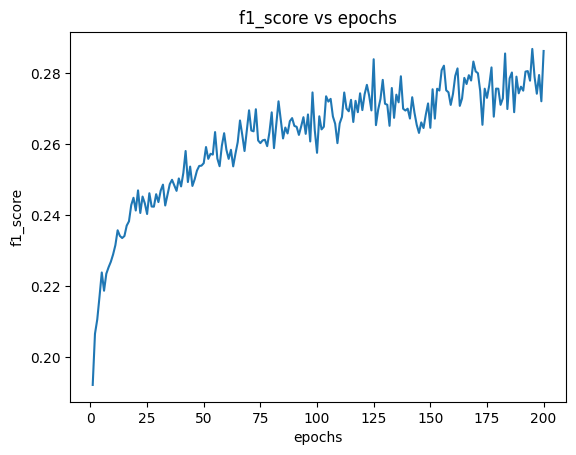

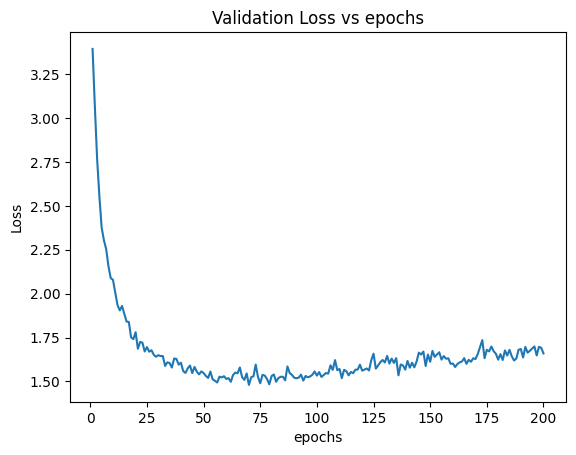

In [6]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

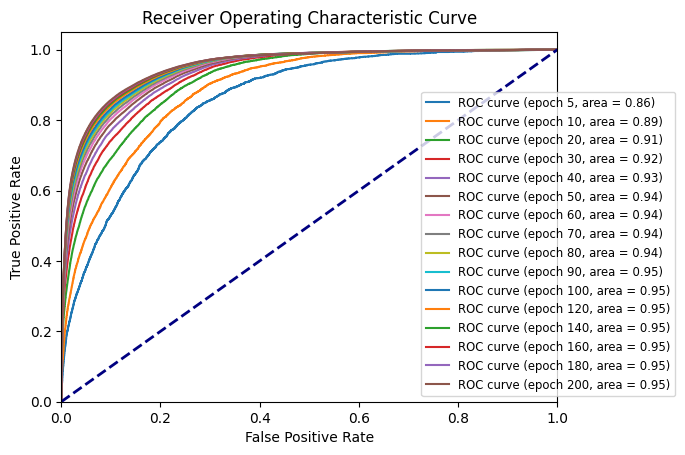

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)